<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [2]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg

    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

Python Environment:
 | Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.2
 | Matplotlib version: 3.9.0
 | NetworkX version: 3.3
 | NetworkX backend: None
 | CuGraph not installed, for better performance install it like this:
	pip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com

Ressources:
 | CPU: 12 cores


# Daten laden

In [3]:
# Graph mit allen Nodes/Edges von den gewählten Papers laden
G = utils.get_graph(GRAPH_PATH, PAPERS)

# Subgraph mit allen Nodes/Edges von Connected Components welche mindestens 1 Schweizer Adresse beinhalten
G_swiss = utils.filter_graph_by_country_name(G, "Switzerland", verbose=True)

Info pre filtering:
Number of edges:  145874
Number of nodes:  108053
Number of weakly connected components:  2643

Filtering the graph after the country "Switzerland"

Info post filtering:
Number of edges:  127482
Number of nodes:  91864
Number of weakly connected components:  53


In [4]:
all_officers_nodes = {node for node, data in G.nodes(data=True) if data.get("node_type") == "Officer"}

swiss_officers_nodes = {node for node, data in G_swiss.nodes(data=True) if data.get("node_type") == "Officer"}

swiss_officers_to_all_officers_raio = len(swiss_officers_nodes)/len(all_officers_nodes)

print(f"Ratio of swiss officers: {swiss_officers_to_all_officers_raio}")

Ratio of swiss officers: 0.8550305240624753


## Specific analysis...

In [17]:
def project_officers_graph(G):
    # Step 1: Make the original graph undirected
    undirected_G = G.to_undirected()

    # Step 2: Project the network to obtain a graph with only officers
    officers_nodes = {node for node, data in undirected_G.nodes(data=True) if data.get("node_type") == "Officer"}

    connecting_entities = 0

    # Step 3: Connect officers if they share the same address or entity
    new_G = nx.Graph()
    for node in officers_nodes:

        # Check if the officer is related to an address or entity
        related_nodes = set()
        for neighbor in undirected_G.neighbors(node):
            neighbor_data = undirected_G.nodes[neighbor]
            if neighbor_data.get("node_type") == "Address" or neighbor_data.get("node_type") == "Entity":
                related_nodes.add(neighbor)

        # Add edges between officers if they share the same address or entity
        for related_node in related_nodes:
            for neighbor in undirected_G.neighbors(related_node):
                if neighbor in officers_nodes:
                    related_data = undirected_G.nodes[related_node]
                    if related_data.get("node_type") == "Entity":
                        connecting_entities += 1
                    new_G.add_edge(node, neighbor)

    return new_G, connecting_entities

# Create the new graph
new_officers_graph, connecting_entities = project_officers_graph(G)

print("Number of conecting entities", connecting_entities)

Number of conecting entities 145212


In [6]:
# List the number of edges and nodes
num_nodes = len(new_officers_graph.nodes)
num_edges = len(new_officers_graph.edges)

print("Number of nodes in the new officers graph:", num_nodes)
print("Number of edges in the new officers graph:", num_edges)

# Calculate the ratio of edges to the number of maximally possible edges
max_possible_edges = num_nodes * (num_nodes - 1) / 2  # Complete graph formula
edge_ratio = num_edges / max_possible_edges if max_possible_edges > 0 else 0  # To handle division by zero

print("Edge ratio (edges / max possible edges):", edge_ratio)


Number of nodes in the new officers graph: 50452
Number of edges in the new officers graph: 499061
Edge ratio (edges / max possible edges): 0.000392134869270035


In [7]:
# Find all cliques in the new officers graph
cliques = list(nx.find_cliques(new_officers_graph))

# Print the number of cliques found
print("Number of cliques found in the new officers graph:", len(cliques))


Number of cliques found in the new officers graph: 24782


In [8]:
from collections import Counter

# Get the length of each clique
clique_lengths = [len(clique) for clique in cliques]

# Count the frequency of each clique length
clique_length_counts = Counter(clique_lengths)

# Sort the clique lengths by frequency
sorted_counts = sorted(clique_length_counts.items(), key=lambda x: x[0], reverse=True)

# Print the sorted frequency counts of clique lengths
print("Frequency counts of clique lengths (sorted):")
for length, count in sorted_counts:
    print(f"Clique length {length}: {count} cliques")

Frequency counts of clique lengths (sorted):
Clique length 652: 1 cliques
Clique length 388: 1 cliques
Clique length 283: 1 cliques
Clique length 275: 1 cliques
Clique length 174: 1 cliques
Clique length 112: 1 cliques
Clique length 99: 1 cliques
Clique length 97: 1 cliques
Clique length 62: 1 cliques
Clique length 60: 1 cliques
Clique length 52: 1 cliques
Clique length 45: 2 cliques
Clique length 40: 1 cliques
Clique length 38: 1 cliques
Clique length 36: 1 cliques
Clique length 35: 1 cliques
Clique length 33: 3 cliques
Clique length 31: 2 cliques
Clique length 30: 2 cliques
Clique length 29: 1 cliques
Clique length 28: 1 cliques
Clique length 27: 5 cliques
Clique length 26: 2 cliques
Clique length 25: 9 cliques
Clique length 24: 5 cliques
Clique length 22: 4 cliques
Clique length 21: 9 cliques
Clique length 20: 9 cliques
Clique length 19: 6 cliques
Clique length 18: 8 cliques
Clique length 17: 9 cliques
Clique length 16: 10 cliques
Clique length 15: 17 cliques
Clique length 14: 19 cl

In [12]:
import matplotlib.pyplot as plt

# Step 1: Get all Swiss officers
swiss_officers = {node for node, data in G_swiss.nodes(data=True) if data.get("node_type") == "Officer"}

# Step 2 & 3: Calculate the ratio of Swiss officers for each clique size
swiss_ratio_by_size = {}
cliques_ratios = []

for clique in cliques:
    clique_size = len(clique)
    
    swiss_count = sum(1 for node in clique if node in swiss_officers)
    swiss_ratio = swiss_count / clique_size if clique_size > 0 else 0
    
    # Skip cliques with size 1
    if clique_size > 1:
        cliques_ratios.append(swiss_ratio)
    
    if clique_size not in swiss_ratio_by_size:
        swiss_ratio_by_size[clique_size] = {"total_cliques": 0, "swiss_count": 0}
    
    swiss_ratio_by_size[clique_size]["total_cliques"] += 1
    swiss_ratio_by_size[clique_size]["swiss_count"] += swiss_count

# Step 4: Calculate the ratio of Swiss officers for each clique size
for size, data in swiss_ratio_by_size.items():
    total_cliques = data["total_cliques"]
    swiss_count = data["swiss_count"]
    swiss_ratio = swiss_count / (total_cliques * size) if total_cliques > 0 else 0
    swiss_ratio_by_size[size]["swiss_ratio"] = swiss_ratio

# Print the results
print("Ratio of Swiss officers for each clique size:")
for size, data in sorted(swiss_ratio_by_size.items()):
    print(f"Clique size {size}: Swiss ratio = {data['swiss_ratio']:.2%} (total cliques: {data['total_cliques']})")


Ratio of Swiss officers for each clique size:
Clique size 1: Swiss ratio = 79.83% (total cliques: 10135)
Clique size 2: Swiss ratio = 86.33% (total cliques: 7543)
Clique size 3: Swiss ratio = 85.58% (total cliques: 3420)
Clique size 4: Swiss ratio = 85.62% (total cliques: 1760)
Clique size 5: Swiss ratio = 88.58% (total cliques: 911)
Clique size 6: Swiss ratio = 86.78% (total cliques: 401)
Clique size 7: Swiss ratio = 85.29% (total cliques: 170)
Clique size 8: Swiss ratio = 83.93% (total cliques: 112)
Clique size 9: Swiss ratio = 88.24% (total cliques: 68)
Clique size 10: Swiss ratio = 85.37% (total cliques: 41)
Clique size 11: Swiss ratio = 88.57% (total cliques: 35)
Clique size 12: Swiss ratio = 90.00% (total cliques: 30)
Clique size 13: Swiss ratio = 94.44% (total cliques: 18)
Clique size 14: Swiss ratio = 94.74% (total cliques: 19)
Clique size 15: Swiss ratio = 82.35% (total cliques: 17)
Clique size 16: Swiss ratio = 90.00% (total cliques: 10)
Clique size 17: Swiss ratio = 100.00% 

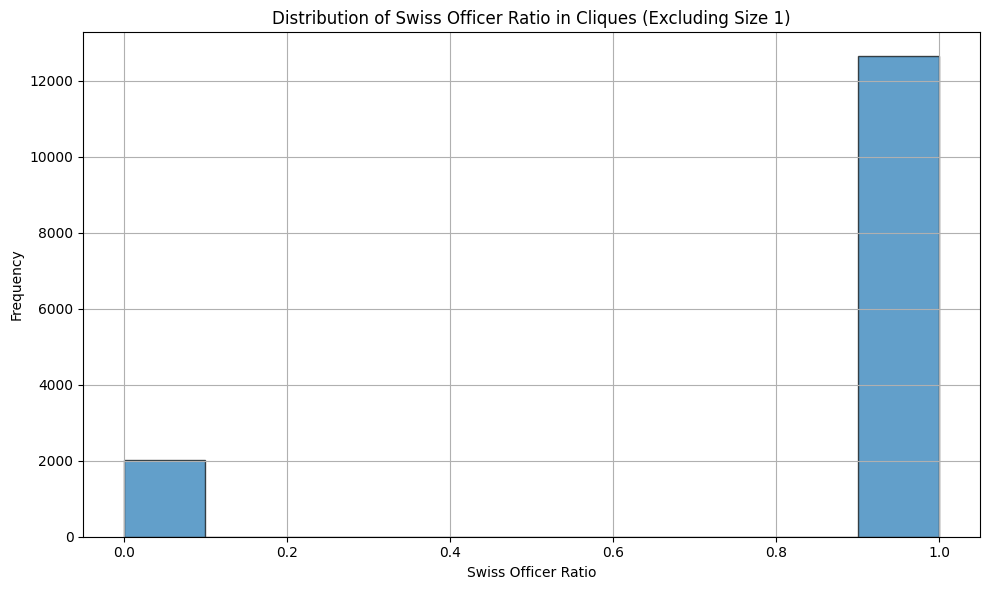

In [14]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(cliques_ratios, edgecolor='black', alpha=0.7)
plt.title('Distribution of Swiss Officer Ratio in Cliques (Excluding Size 1)')
plt.xlabel('Swiss Officer Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
np.unique(cliques_ratios)

array([0., 1.])

Cliques are always swiss or not. And the rest of the cliques must always be from a single country.

This looks like, that all edges were created based on addresses, as this is the way swiss officers are defined. And at first this poses the question, whether any edges were created based on entities. But it could also be, that all officers connected to an entity are either from switzerland or from another country.

In [18]:
connecting_entities / num_edges

0.29097044249099807

As we can see above: 29% of edges are from entities which connect two officers. So the latter claim is true, that all officers connected to an entity are either from switzerland or from another country.

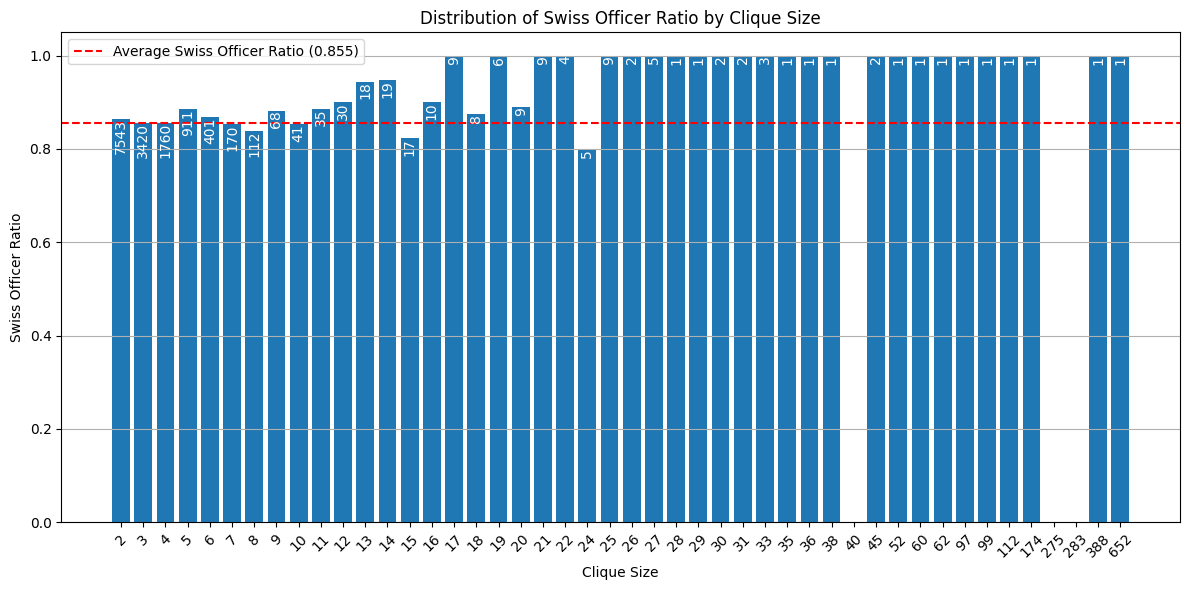

In [10]:
import matplotlib.pyplot as plt

# Extract clique sizes and Swiss ratios
clique_sizes = sorted(swiss_ratio_by_size.keys())
swiss_ratios = [swiss_ratio_by_size[size]['swiss_ratio'] for size in clique_sizes]
clique_counts = [swiss_ratio_by_size[size]['total_cliques'] for size in clique_sizes]

# Plot the distribution as a bar plot with categorical x-axis
plt.figure(figsize=(12, 6))
bars = plt.bar([str(size) for size in clique_sizes], swiss_ratios)
plt.title('Distribution of Swiss Officer Ratio by Clique Size')
plt.xlabel('Clique Size')
plt.ylabel('Swiss Officer Ratio')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.grid(axis='y')

# Add average line for Swiss officers ratio of 0.85
plt.axhline(y=swiss_officers_to_all_officers_raio, color='red', linestyle='--', label=f'Average Swiss Officer Ratio ({swiss_officers_to_all_officers_raio:.3})')
plt.legend()

# Add clique counts as text labels inside the bars
for bar, count in zip(bars, clique_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='top', rotation=90, color="white")

plt.tight_layout()
plt.show()
